In [2]:
import argparse
import scipy.io as scio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import random
from utils import weights_init, compute_acc
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm


  # 输入参数

In [157]:
parser = argparse.ArgumentParser()
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=1, help='input batch size')
parser.add_argument('--signalFeatures', type=int, default=6, help='the features of signal')
parser.add_argument('--signalPoints', type=int, default=6, help='the points of signal')
parser.add_argument('--nz', type=int, default=110, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--Dlr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--Glr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--num_classes', type=int, default=10, help='Number of classes for AC-GAN')
parser.add_argument('--gpu_id', type=int, default=0, help='The ID of the specified GPU')
parser.add_argument('--window', type=int, default=4, help='The size of slide window')
parser.add_argument('--slide_stride', type=int, default=1, help='The stride of slide window')
parser.add_argument('--transform', default='normalize', help='transform data : normalize | maxmin_01:between(0,1) | maxmin_11:between(-1,1)')

opt = parser.parse_args(['--cuda',
                         '--batchSize','1000',
                         '--niter','500',
                         '--workers','0',
                         '--gpu_id','0',
                         '--nz','100',
                         '--num_classes','6',
                         '--signalFeatures','1',
                         '--signalPoints','6',
                         '--window','4',
                         '--slide_stride','1',
                         '--Dlr','0.001',
                         '--Glr','0.0001',
                         '--transform','maxmin_11'])
print(opt)

# specify the gpu id if using only 1 gpu
if opt.ngpu == 1:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(opt.gpu_id)

device = torch.device("cuda:"+str(opt.gpu_id) if torch.cuda.is_available() else "cpu")


try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")


# some hyper parameters
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
num_classes = int(opt.num_classes)
nc = 3


Namespace(Dlr=0.001, Glr=0.0001, batchSize=1000, beta1=0.5, cuda=True, gpu_id=0, manualSeed=None, ndf=64, netD='', netG='', ngf=64, ngpu=1, niter=500, num_classes=6, nz=100, outf='.', signalFeatures=1, signalPoints=6, slide_stride=1, transform='maxmin_11', window=4, workers=0)
Random Seed:  9837


 # 导入处理数据

In [158]:
def normalize(data):
    normalize_data = (data - data.mean(axis=0))/data.std(axis=0)
    return normalize_data

def maxmin_01(data):
    maxmin_data = (data - data.min())/(data.max()-data.min())
    return maxmin_data

def maxmin_11(data):
    maxmin_data = (data - data.min())/(data.max()-data.min())*2-1
    return maxmin_data



In [205]:
data_1 = torch.from_numpy(scio.loadmat("data/CSTH/mode_1_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_1 = data_1[:200]
data_2 = torch.from_numpy(scio.loadmat("data/CSTH/mode_2_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_3 = torch.from_numpy(scio.loadmat("data/CSTH/mode_3_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_4 = torch.from_numpy(scio.loadmat("data/CSTH/mode_4_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_5 = torch.from_numpy(scio.loadmat("data/CSTH/mode_5_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_6 = torch.from_numpy(scio.loadmat("data/CSTH/mode_6_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)



In [206]:
original_data = {0:data_1,1:data_2,2:data_3,3:data_4,4:data_5,5:data_6}
data_mean = torch.cat((data_1.mean(axis=0),data_2.mean(axis=0),data_3.mean(axis=0),data_4.mean(axis=0),data_5.mean(axis=0),data_6.mean(axis=0)),0)
data_std = torch.cat((data_1.std(axis=0),data_2.std(axis=0),data_3.std(axis=0),data_4.std(axis=0),data_5.std(axis=0),data_6.std(axis=0)),0)
data_max = torch.tensor([data_1.max(),data_2.max(),data_3.max(),data_4.max(),data_5.max(),data_6.max()]).unsqueeze(0).to(device)
data_min = torch.tensor([data_1.min(),data_2.min(),data_3.min(),data_4.min(),data_5.min(),data_6.min()]).unsqueeze(0).to(device)


 ## 归一化数据

In [207]:
# 对每个类别分别做了归一化，应该是错的，这样会导致分类数据混叠
# if opt.transform == 'normalize':
#     ndata_1 = normalize(data_1)
#     ndata_2 = normalize(data_2)
#     ndata_3 = normalize(data_3)
#     ndata_4 = normalize(data_4)
#     ndata_5 = normalize(data_5)
#     ndata_6 = normalize(data_6)
# elif opt.transform == 'maxmin':
#     ndata_1 = maxmin(data_1)
#     ndata_2 = maxmin(data_2)
#     ndata_3 = maxmin(data_3)
#     ndata_4 = maxmin(data_4)
#     ndata_5 = maxmin(data_5)
#     ndata_6 = maxmin(data_6)

# x_data = torch.cat((ndata_1,ndata_2,ndata_3,ndata_4,ndata_5,ndata_6),0)
# label_1 = torch.zeros(ndata_1.shape[0])
# label_2 = torch.ones(ndata_2.shape[0])
# label_3 = torch.ones(ndata_3.shape[0])*2
# label_4 = torch.ones(ndata_4.shape[0])*3
# label_5 = torch.ones(ndata_5.shape[0])*4
# label_6 = torch.ones(ndata_6.shape[0])*5
# y_data = torch.cat((label_1,label_2,label_3,label_4,label_5,label_6))



In [208]:
# 将不同类别的数据拼接
x_data = torch.cat((data_1,data_2,data_3,data_4,data_5,data_6),0)
label_1 = torch.zeros(data_1.shape[0])
label_2 = torch.ones(data_2.shape[0])
label_3 = torch.ones(data_3.shape[0])*2
label_4 = torch.ones(data_4.shape[0])*3
label_5 = torch.ones(data_5.shape[0])*4
label_6 = torch.ones(data_6.shape[0])*5
y_data = torch.cat((label_1,label_2,label_3,label_4,label_5,label_6))



In [209]:
all_data_mean = x_data.mean()
all_data_std = x_data.std()
all_data_max = x_data.max()
all_data_min = x_data.min()

if opt.transform == 'normalize':
    x_data = normalize(x_data)
elif opt.transform == 'maxmin_01':
    x_data = maxmin_01(x_data)
elif opt.transform == 'maxmin_11':
    x_data = maxmin_11(x_data)



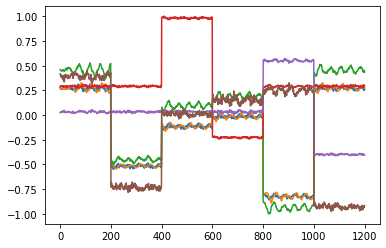

In [210]:
plt.plot(x_data.detach().cpu()[:,0,:])



In [211]:
deal_dataset = TensorDataset(x_data, y_data)
dataloader = DataLoader(dataset=deal_dataset,
                        batch_size=opt.batchSize,
                        shuffle=True,
                        num_workers=opt.workers)



In [166]:
# 定义生成器
class _netG(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.ngpu = int(opt.ngpu)
        self.nz = int(opt.nz)
        self.points = int(opt.signalPoints)
        self.batch_size = int(opt.batchSize)
        self.features = int(opt.signalFeatures)

        self.fc1 = nn.Linear(100,36)
        # output batchsize*36*1

        self.tconv2 = nn.Sequential(
            nn.ConvTranspose1d(36,18,2,1,0, bias=True),
            nn.BatchNorm1d(18),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.1, inplace=False)
        )# output batchsize*channel(dim)*points batchsize*18*2

        self.tconv3 = nn.Sequential(
            nn.ConvTranspose1d(18,9,2,1,0, bias=True),
            nn.BatchNorm1d(9),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.1, inplace=False)
        )# output batchsize*channel(dim)*points batchsize*6*4

        self.tconv4 = nn.Sequential(
            nn.ConvTranspose1d(9,opt.signalFeatures,self.points-2,1,0, bias=True),
            nn.BatchNorm1d(opt.signalFeatures),
            nn.Tanh()
            # nn.Dropout(0.1, inplace=False)
        )# output batchsize*channel(dim)*points batchsize*9*3
        

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            input = input.view(-1, self.nz)
            fc1 = nn.parallel.data_parallel(self.fc1, input, range(self.ngpu))
            fc1 = fc1.view(-1, 36, 1)
            tconv2 = nn.parallel.data_parallel(self.tconv2, fc1, range(self.ngpu))
            tconv3 = nn.parallel.data_parallel(self.tconv3, tconv2, range(self.ngpu))
            tconv4 = nn.parallel.data_parallel(self.tconv4, tconv3, range(self.ngpu))
            output = tconv4
        else:
            input = input.view(-1, self.nz)
            fc1 = self.fc1(input)
            fc1 = fc1.view(-1, 36, 1)
            tconv2 = self.tconv2(fc1)
            tconv3 = self.tconv3(tconv2)
            tconv4 = self.tconv4(tconv3)
            output = tconv4
        return output



In [167]:
# 定义鉴别器
class _netD(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.ngpu = int(opt.ngpu)
        self.num_classes = opt.num_classes
        self.points = int(opt.signalPoints)
        self.features = int(opt.signalFeatures)

        self.conv1 = nn.Sequential(
            nn.Conv1d(opt.signalFeatures,12,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1, inplace=False)
        )# output [1, 12, 3]
        self.conv2 = nn.Sequential(
            nn.Conv1d(12,24,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1, inplace=False)
        )# output [1, 24, 1]
        self.conv3 = nn.Sequential(
            nn.Conv1d(24,48,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1, inplace=False)
        )# output [1, 48, 1]

        self.fc_dis = spectral_norm(nn.Linear(48*(self.points-3), 1))
        self.fc_aux = spectral_norm(nn.Linear(48*(self.points-3), self.num_classes))
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        batchsize = input.shape[0]
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            conv1 = nn.parallel.data_parallel(self.conv1, input, range(self.ngpu))
            conv2 = nn.parallel.data_parallel(self.conv2, conv1, range(self.ngpu))
            conv3 = nn.parallel.data_parallel(self.conv3, conv2, range(self.ngpu))
            flat = conv3.view(-1, 48*1)
            fc_dis = nn.parallel.data_parallel(self.fc_dis, flat, range(self.ngpu))
            fc_aux = nn.parallel.data_parallel(self.fc_aux, flat, range(self.ngpu))
        else:
            conv1 = self.conv1(input)
            conv2 = self.conv2(conv1)
            conv3 = self.conv3(conv2)
            flat = conv3.view(batchsize, -1)
            fc_dis = self.fc_dis(flat)
            fc_aux = self.fc_aux(flat)
        classes = self.softmax(fc_aux)
        realfake = self.sigmoid(fc_dis).view(-1, 1).squeeze(1)
        return realfake, classes



In [168]:
# 初始化生成器和鉴别器
netG = _netG(opt).to(device)
netG.apply(weights_init)
netD = _netD(opt).to(device)
netD.apply(weights_init)



_netD(
  (conv1): Sequential(
    (0): Conv1d(1, 12, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(12, 24, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(24, 48, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc_dis): Linear(in_features=144, out_features=1, bias=True)
  (fc_aux): Linear(in_features=144, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
)

In [169]:
# 定义鉴别和辅助分类损失函数
dis_criterion = nn.BCELoss().to(device)
aux_criterion = nn.CrossEntropyLoss().to(device)


  # 定义优化器

In [170]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.Dlr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.Glr, betas=(opt.beta1, 0.999))


  # 训练

  # 初始化变量

In [171]:
# tensor placeholders
noise = torch.FloatTensor(opt.batchSize, nz, 1).to(device)
dis_label = torch.FloatTensor(opt.batchSize).to(device)
aux_label = torch.LongTensor(opt.batchSize).to(device)
D_real_label = 1
# D_real_label = 0.9+random.random()/10
G_real_label = 1
fake_label = 0
# fake_label = random.random()/10



In [172]:
avg_loss_D = 0.0
avg_loss_G = 0.0
avg_loss_A = 0.0



In [173]:
aux_loss_coef = 1



In [199]:
for epoch in range(opt.niter):
# for epoch in range(1000):
    for i, data in enumerate(dataloader, 0):
        if epoch==400:
            pass

        #############################
        ## (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #############################
        # train with real
        netD.zero_grad()
        real_cpu, label = data
        input_samples = real_cpu
        batch_size = real_cpu.shape[0]
        dis_label.resize_(batch_size).fill_(D_real_label)
        # dis_label[:int(opt.batchSize*0.1)] = 0  # 翻转部分标签

        aux_label.resize_(batch_size).copy_(label)
        dis_output, aux_output = netD(input_samples)

        dis_errD_real = dis_criterion(dis_output, dis_label)
        aux_errD_real = aux_criterion(aux_output, aux_label)
        errD_real = (dis_errD_real + aux_loss_coef*aux_errD_real)/4
        errD_real.backward()
        D_x = dis_output.mean()

        # compute the current classification accuracy
        accuracy = compute_acc(aux_output, aux_label)

        # train with fake
        label = torch.randint_like(aux_label, 0, num_classes)
        noise = torch.randn(batch_size, nz,1,1).to(device)
        class_onehot = torch.zeros((batch_size, num_classes)).to(device)
        class_onehot[np.arange(batch_size), label] = 1
        noise[np.arange(batch_size), :num_classes, 0, 0] = class_onehot[np.arange(batch_size)]
        aux_label.copy_(label)

        fake = netG(noise)
        dis_label.fill_(fake_label)
        dis_output, aux_output = netD(fake.detach())
        dis_errD_fake = dis_criterion(dis_output, dis_label)
        aux_errD_fake = aux_criterion(aux_output, aux_label)
        errD_fake = (dis_errD_fake + aux_loss_coef*aux_errD_fake)/4
        errD_fake.backward()
        D_G_z1 = dis_output.mean()
        errD = (errD_real + errD_fake)/4
        optimizerD.step()

        #############################
        ## (2) Update G network: maximize log(D(G(z)))
        #############################
        if epoch%1==0:
            G_more = 0
            if G_more:
                for Gj in range(5):
                    label = torch.randint_like(aux_label, 0, num_classes)
                    noise = torch.randn(batch_size, nz,1,1).to(device)
                    class_onehot = torch.zeros((batch_size, num_classes)).to(device)
                    class_onehot[np.arange(batch_size), label] = 1
                    noise[np.arange(batch_size), :num_classes, 0, 0] = class_onehot[np.arange(batch_size)]
                    aux_label.copy_(label)

                    fake = netG(noise)
                    netG.zero_grad()
                    dis_label.fill_(G_real_label)
                    dis_output, aux_output = netD(fake)
                    dis_errG = dis_criterion(dis_output, dis_label)
                    aux_errG = aux_criterion(aux_output, aux_label)
                    errG = (dis_errG + aux_loss_coef*aux_errG)/2
                    errG.backward()
                    D_G_z2 = dis_output.mean()
                    optimizerG.step()
            else:
                netG.zero_grad()
                dis_label.fill_(G_real_label)
                dis_output, aux_output = netD(fake)
                dis_errG = dis_criterion(dis_output, dis_label)
                aux_errG = aux_criterion(aux_output, aux_label)
                errG = (dis_errG + aux_loss_coef*aux_errG)/2
                errG.backward()
                D_G_z2 = dis_output.mean()
                optimizerG.step()


        # compute the average loss
        curr_iter = 1
        all_loss_G = avg_loss_G * curr_iter
        all_loss_D = avg_loss_D * curr_iter
        all_loss_A = avg_loss_A * curr_iter
        all_loss_G += errG.item()
        all_loss_D += errD.item()
        all_loss_A += accuracy
        avg_loss_G = all_loss_G / (curr_iter + 1)
        avg_loss_D = all_loss_D / (curr_iter + 1)
        avg_loss_A = all_loss_A / (curr_iter + 1)
        print('[%d/%d][%d/%d] Loss_D: %.4f (%.4f) Loss_G: %.4f (%.4f) D(x): %.4f D(G(z)): %.4f / %.4f Acc: %.4f (%.4f)'
                % (epoch, opt.niter, i, len(dataloader),
                errD.item(), avg_loss_D, errG.item(), avg_loss_G, D_x, D_G_z1, D_G_z2, accuracy, avg_loss_A))



172) Loss_G: 0.8713 (0.8684) D(x): 0.5016 D(G(z)): 0.5020 / 0.4975 Acc: 100.0000 (100.0000)
[421/500][0/2] Loss_D: 0.2173 (0.2173) Loss_G: 0.8729 (0.8706) D(x): 0.4963 D(G(z)): 0.4975 / 0.4959 Acc: 100.0000 (100.0000)
[421/500][1/2] Loss_D: 0.2172 (0.2172) Loss_G: 0.8729 (0.8717) D(x): 0.4960 D(G(z)): 0.4957 / 0.4960 Acc: 100.0000 (100.0000)
[422/500][0/2] Loss_D: 0.2174 (0.2173) Loss_G: 0.8693 (0.8705) D(x): 0.4962 D(G(z)): 0.4979 / 0.4996 Acc: 100.0000 (100.0000)
[422/500][1/2] Loss_D: 0.2175 (0.2174) Loss_G: 0.8648 (0.8676) D(x): 0.4987 D(G(z)): 0.5008 / 0.5040 Acc: 100.0000 (100.0000)
[423/500][0/2] Loss_D: 0.2174 (0.2174) Loss_G: 0.8604 (0.8640) D(x): 0.5041 D(G(z)): 0.5059 / 0.5084 Acc: 100.0000 (100.0000)
[423/500][1/2] Loss_D: 0.2175 (0.2175) Loss_G: 0.8622 (0.8631) D(x): 0.5067 D(G(z)): 0.5090 / 0.5068 Acc: 100.0000 (100.0000)
[424/500][0/2] Loss_D: 0.2173 (0.2174) Loss_G: 0.8631 (0.8631) D(x): 0.5067 D(G(z)): 0.5072 / 0.5059 Acc: 100.0000 (100.0000)
[424/500][1/2] Loss_D: 0.2

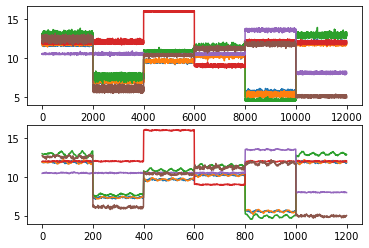

In [204]:
batch_size = real_cpu.shape[0]
batch_size = 12000
dis_label.resize_(batch_size).fill_(D_real_label)
# dis_label[:int(opt.batchSize*0.1)] = 0  # 翻转部分标签

aux_label = torch.randint(0,num_classes,(batch_size,))
label = torch.randint_like(aux_label, 0, num_classes)
dim = 5
label[:] = dim
# label[:35] = 0
# label[35:70] = 1
# label[70:105] = 2
# label[105:140] = 3
# label[140:175] = 4
# label[175:] = 5

label[:2000] = 0
label[2000:4000] = 1
label[4000:6000] = 2
label[6000:8000] = 3
label[8000:10000] = 4
label[10000:] = 5

noise = torch.randn(batch_size, nz,1,1).to(device)
class_onehot = torch.zeros((batch_size, num_classes)).to(device)
class_onehot[np.arange(batch_size), label] = 1
noise[np.arange(batch_size), :num_classes, 0, 0] = class_onehot[np.arange(batch_size)]
aux_label.copy_(label)

fake = netG(noise)
if opt.transform == 'normalize':
    # fake = fake*data_std[dim]+data_mean[dim]
    fake = fake*all_data_std + all_data_mean
    plot_x_data = (x_data*all_data_std+all_data_mean).detach().cpu()[:,0,:]
    pass
elif opt.transform == 'maxmin_01':
    fake = fake*(all_data_max-all_data_min)+all_data_min
    plot_x_data = (x_data*(all_data_max-all_data_min)+all_data_min).detach().cpu()[:,0,:]
elif opt.transform == 'maxmin_11':
    fake = (fake+1)/2*(all_data_max-all_data_min)+all_data_min
    plot_x_data = ((x_data+1)/2*(all_data_max-all_data_min)+all_data_min).detach().cpu()[:,0,:]

plot_fake_sample = fake.permute(0,2,1).detach().cpu()
plt.figure()
plt.subplot(2,1,1)
plt.plot(plot_fake_sample[:,:,0])
plt.subplot(2,1,2)
# plt.plot(original_data[dim][:,0,:].detach().cpu())
# plt.plot(x_data.detach().cpu()[:,0,:])
plt.plot(plot_x_data)
plt.savefig('fig1.png')

aux_label = torch.LongTensor(opt.batchSize).to(device)

In [190]:
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))



tensor(3.)

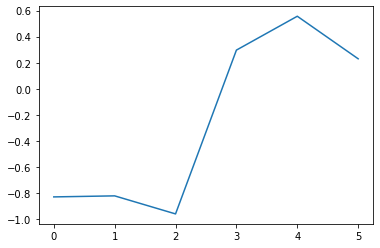

In [191]:
sample_plot = 7
plt.figure()
plt.plot((data[0][2].view(-1,1).detach().cpu()).numpy())
data[1][sample_plot]

